In [45]:
from pathlib import Path
import pandas as pd

def load_seed_comparisons(root_dir: str) -> dict[str, pd.DataFrame]:
    """Return DataFrames keyed by seed folder names (e.g., seed_1)."""
    root = Path(root_dir)
    data = {}
    for seed_dir in sorted(root.glob("seed_*")):
        if not seed_dir.is_dir():
            continue
        csv_path = seed_dir / f"{seed_dir.name}_lnz_comparison.csv"
        if not csv_path.is_file():
            continue  # or raise FileNotFoundError(csv_path)
        data[seed_dir.name] = pd.read_csv(csv_path)
    return data




In [47]:
comparisons = load_seed_comparisons(
    "/fred/oz303/avajpeyi/studies/morphZ_casestudy_CBC_pe/fast_pp/outdir"
)
seed1_df = comparisons["seed_1"]
comparisons

{'seed_1':            method           lnz   lnz_err
 0         dynesty -15941.208073  0.091930
 1            mcmc -15941.004256  0.117886
 2  dynesty_morphz -15941.047338  0.286736
 3     mcmc_morphz -15941.202887  0.302975,
 'seed_11':            method           lnz   lnz_err
 0         dynesty -16181.055183  0.099449
 1            mcmc -16179.716625  0.124355
 2  dynesty_morphz -16180.824800  0.467893
 3     mcmc_morphz -16180.738515  0.434432,
 'seed_12':            method           lnz   lnz_err
 0         dynesty -16303.593966  0.110125
 1            mcmc -16302.616260  0.135760
 2  dynesty_morphz -16303.656807  0.886014
 3     mcmc_morphz -16304.010330  0.919383,
 'seed_13':            method           lnz   lnz_err
 0         dynesty -16399.591357  0.110167
 1            mcmc -16398.747001  0.118047
 2  dynesty_morphz -16400.033964  0.532416
 3     mcmc_morphz -16399.617681  0.543475,
 'seed_14':            method           lnz   lnz_err
 0         dynesty -16178.888337  0.108

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_delta_lnz_spaghetti(
    results_by_seed,
    baseline='dynesty',
    methods=('dynesty', 'mcmc', 'dynesty_morphz', 'mcmc_morphz'),
    sample=None,
    propagate_baseline_error=False,
    colors=None,
    random_state=None,
):
    """
    results_by_seed: dict[str -> pd.DataFrame] with columns ['method','lnz','lnz_err']
    baseline: method name to anchor at x=0
    methods: order to plot
    sample: optional int to subsample seeds
    propagate_baseline_error: if True, xerr for non-baseline methods is
      sqrt(err_method^2 + err_baseline^2). If False (default), uses each method's own err.
    colors: optional dict to override colors by method
    """

    # choose seeds (optional subsample)
    seeds = list(results_by_seed.keys())
    if sample is not None and sample < len(seeds):
        rng = np.random.default_rng(random_state)
        seeds = list(rng.choice(seeds, size=sample, replace=False))

    # build arrays aligned by methods
    lnz_list, err_list, kept = [], [], []
    needed = set(methods)
    for s in seeds:
        df = results_by_seed[s]
        if not needed.issubset(set(df['method'])):
            continue  # skip seeds missing a method
        row = df.set_index('method').loc[list(methods)]
        lnz_list.append(row['lnz'].to_numpy())
        err_list.append(row['lnz_err'].to_numpy())
        kept.append(s)

    if not kept:
        raise ValueError("No seeds contain all requested methods.")

    lnz = np.asarray(lnz_list)  # (n_seeds, M)
    err = np.asarray(err_list)
    seeds = kept

    base_idx = methods.index(baseline)
    delta = lnz - lnz[:, [base_idx]]  # broadcast: baseline -> 0

    # choose error model for delta
    if propagate_baseline_error:
        rel_err = np.sqrt(err**2 + err[:, [base_idx]]**2)
        rel_err[:, base_idx] = err[:, base_idx]
    else:
        rel_err = err

    # sort by baseline lnz (original, not delta) to reduce crossings
    order = np.argsort(lnz[:, base_idx])
    seeds = [seeds[i] for i in order]
    delta = delta[order]
    rel_err = rel_err[order]
    lnz = lnz[order]

    # colors (matching the image vibe)
    default_colors = {
        'dynesty': "#676767",        # green/teal (baseline)
        'mcmc': "#FF7676",           # blue
        'dynesty_morphz': "#000000", # yellow/amber
        'mcmc_morphz': "#ff0000",    # orange
    }
    if colors:
        default_colors.update(colors)

    fig, ax = plt.subplots(figsize=(11, 7))
    y = np.arange(len(seeds))

    # plot points + error bars
    for j, m in enumerate(methods):
        ax.errorbar(
            delta[:, j], y, xerr=rel_err[:, j],
            fmt='o', ms=4, capsize=1, elinewidth=1.5,
            color=default_colors.get(m),
            alpha=0.7,
            label=f"{m} (baseline)" if j == base_idx else m
        )
    ax.vlines(x=1,ymin=0,ymax=88,linestyles='dashed',alpha=0.4,colors="grey")
    ax.vlines(x=-1,ymin=0,ymax=88,linestyles='dashed',alpha=0.4,colors="grey")

    # connect methods within each seed (light spaghetti lines)
    for k in range(len(seeds)):
        ax.plot(delta[k, :], [y[k]] * len(methods), '-', alpha=0.15, color='0.3')

    ax.axvline(0.0, color='k', lw=0.8, alpha=0.6)
    step = max(1, len(y) // 12)
    ax.set_yticks(y[::step])
    ax.set_yticklabels([seeds[i] for i in range(0, len(seeds), step)])
    ax.set_xlabel('Δ log(z) relative to dynesty')
    ax.set_xlim([-5,5])
    ax.set_title('Per-seed Δlog(z) ±1σ by method (dynesty baseline)')
    ax.legend(title='Methods', loc='lower left')
    fig.tight_layout()
    return fig, ax


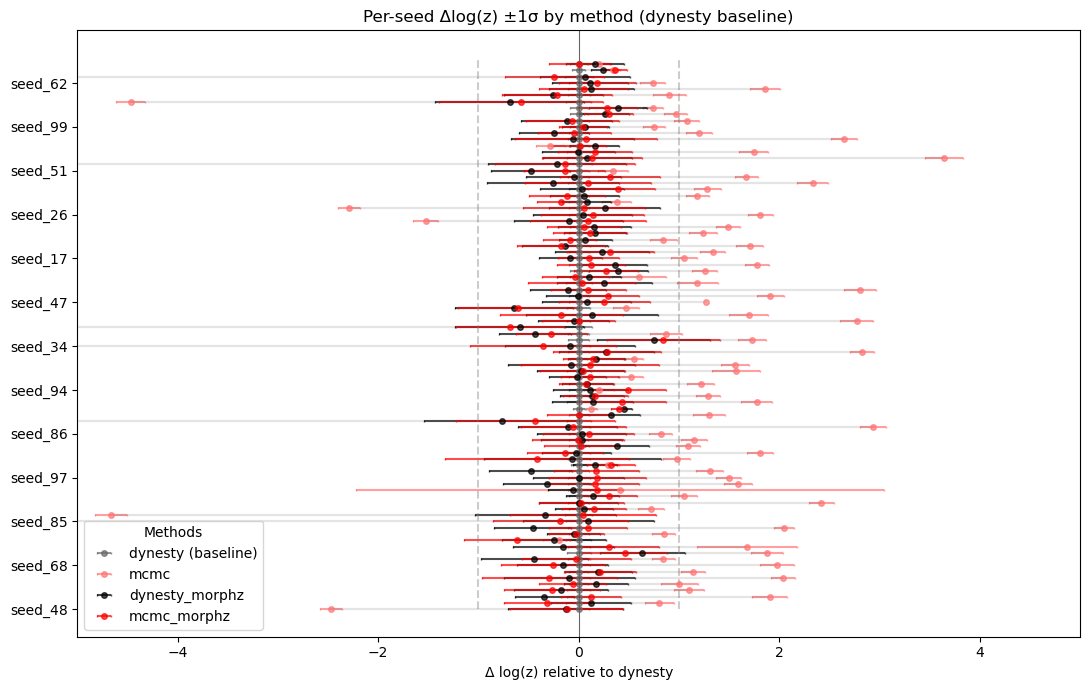

In [63]:
# comparisons = load_seed_comparisons(root_dir)
sorted_d = dict(sorted(comparisons.items(), reverse=False))
fig, ax = plot_delta_lnz_spaghetti(sorted_d)
# If you prefer propagated errors for deltas:
# fig, ax = plot_delta_lnz_spaghetti(results_by_seed, propagate_baseline_error=True)
plt.show()
